# Scikit-learn + Dask

Scikit-learn is a popular machine learning library whose API is easy to use because it has been inspired by other machine learning libraries. It encompasses a wide variety of problem formulations, ranging from simple linear models to more complex clustering or decomposition formulations. Scikit-learn works great for problems that fit on a single machine, but struggles for larger problems. This has even gotten a page in their user guide, "[Strategies to scale computationally: bigger data][strat]".

Using scikit-learn estimators with Dask-ML helps scale to large datasets. All the computation remains on scikit-learn's shoulders but the data management is handled by Dask. This allows scaling to large datasets distributed across many machines, or to datasets that do not fit in memory.

This example wraps a scikit-learn estimator with a Dask-ML estimator suited for incremental learning: https://dask-ml.readthedocs.io/en/latest/modules/generated/dask_ml.wrappers.Incremental.html.

This example will show

* wrapping an estimator that implements `partial_fit` with `dask_ml`
* training, predicting, and scoring on this wrapped classifier
* integration with other parts of scikit-learn (e.g., with GridSearchCV)

Though this example is made with a scikit-learn estimator, it will work for any class that implements the `partial_fit` and the [scikit-learn base estimator API].

[scikit-learn base estimator API]:http://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html

<img src="http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png">
<img src="https://www.continuum.io/sites/default/files/dask_stacked.png" width="100px">

[strat]:http://scikit-learn.org/stable/modules/scaling_strategies.html


## Dask setup

Creating a distributed scheduler will provide good feedback because we can view the dask.distributed dashboard. This will provide progress and performance metrics, including visualization of jobs that are running.

In [1]:
from distributed import Client, LocalCluster
client = Client()
client

Client Scheduler: tcp://127.0.0.1:49689 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


This is not necessary but is encouraged because it gives feedback.

## Data creation
We will create synthetic data because we are more interested in showing how these data flow through the estimator, rather than any cool insights we can glean from the data.

Let's create a synthetic dataset that's not too large (so it runs in a reasonable time) and but is realistically large and can show Dask features. We have 100,000 examples and 100 features in this dataset we create.

In [2]:
import numpy as np
import dask.array as da
from dask_ml.datasets import make_classification
import dask

n, d = 100000, 100

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 10)
X

dask.array<normal, shape=(100000, 100), dtype=float64, chunksize=(10000, 100)>

If this were a real use case, the Dask arrays `X` and `y` would be real data (e.g., from file system or a database). There are a plethora of methods to create Dask arrays (https://dask.pydata.org/en/latest/array-creation.html) and Dask dataframes (https://dask.pydata.org/en/latest/dataframe-create.html).

We are interested in evaluating this model, so we don't want to learn from test data (ever hear of teaching to the test?). This prevents against that.

In [3]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train

dask.array<concatenate, shape=(90000, 100), dtype=float64, chunksize=(9000, 100)>

We haven't done any work yet – Dasks operations are lazy, so we've only described to Dask what we want to do. When we tell Dask we want to do work, it'll be done in parallel on a worker or out-of-core.

## Model creation

We make the underlying scikit-learn estimator as usual:

In [4]:
from sklearn.linear_model import SGDClassifier

est = SGDClassifier(loss='log', penalty='l1', tol=1e-3, average=True)

Now, let's wrap it with `dask_ml.wrappers.Incremental`. `Incremental` is a meta-estimator, or an estimator that takes in another estimator.

In [5]:
from dask_ml.wrappers import Incremental

inc = Incremental(est, scoring='accuracy')

`Incremental` does data management: it calls `est.partial_fit` on each chunk of the passed data. Dask moves the model to different chunks of the data (or vice versa) to let this happen. Note: Dask-ML `Incremental` gives data to Scikit-learn and does not change the underlying optimization algorithm that Scikit-learn uses. There are different optimization algorithms in Dask-ML that do this, especially for clustering and matrix decomposition.

Our model (SGDClassifier here) must implement `partial_fit` to be used with `Incremental`. A list of models that implement this API is available on a scikit-learn documentation page under "Incremental learning": http://scikit-learn.org/stable/modules/scaling_strategies.html#incremental-learning

It is important to specify the scoring parameter in `Incremental`; otherwise, scikit-learn scorers are fed Dask arrays (which they're not optimized for).


[1]:http://scikit-learn.org/stable/modules/scaling_strategies.html
[inc]:http://scikit-learn.org/stable/modules/scaling_strategies.html#incremental-learning

## Model training
Of course, `Incremental` implements a `fit` method:

In [6]:
inc.fit(X_train, y_train, classes=da.unique(y))

Incremental(SGDClassifier(alpha=0.0001, average=True, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False))

`fit` will perform one loop over the dataset, calling `partial_fit` over each chunk in the Dask array.

`fit` and `partial_fit` are aliased to the same function that trains over one complete pass over the dataset. Let's call `partial_fit` many times, and do 20 passes over the dataset. We'll have to create our estimators `est` and `inc` because they've already been fitted through above.

In [7]:
from dask import delayed
import sklearn

est = SGDClassifier(loss='log', penalty='l1', tol=1e-3, average=True)
inc_delayed = delayed(Incremental(est, scoring='accuracy'))

delayed_data = []
for epoch in range(40):
    inc = delayed(inc_delayed.partial_fit)(
        X_train, y_train, classes=da.unique(y)
    )
    inc_delayed = delayed(inc)
    delayed_data += [{'epoch': epoch,
                      'test_score': delayed(inc.score)(X_test, y_test)}]
inc

Delayed('partial_fit-b99fd02d-8dfb-4d4e-a4cb-31bd81e4e688')

In [8]:
%%time
inc, data = dask.compute(inc, delayed_data)

CPU times: user 813 ms, sys: 92 ms, total: 905 ms
Wall time: 5.41 s


This for-loop is simple, even though it's doing a fairly complex operation. One could imagine having each iteration of this for-loop to be complicated and manage data IO as well as giving the estimator different chunks. With distributed, the IO cost is paid once at the beginning then not once again.

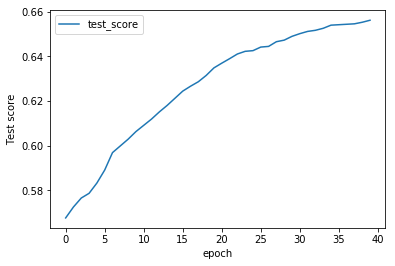

In [9]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
df.plot(x='epoch', y='test_score')
_ = plt.ylabel('Test score')

## Predicting

We can also call `Incremental.score` to compute the accuracy for us:

In [10]:
inc.score(X_test, y_test)

0.6561

We can also compute the accuracy ourselves by using the raw dask arrays:

In [11]:
y_pred = inc.predict(X_test)
errors = np.abs(y_pred - y_test)
accuracy = 1 - errors.mean()
accuracy

dask.array<sub, shape=(), dtype=float64, chunksize=()>

In [12]:
accuracy.compute()

0.6561

## Grid search

There a lot of parameters to feed `SGDClassifier`, and this accuracy depends on those parameters, and it may not be as high as it can be. We'll consider two of the most basic parameters, specifying a different loss function and different amount of penalty. This is the problem of hyperparameter optimization, something Dask-ML supports: https://dask-ml.readthedocs.io/en/latest/hyper-parameter-search.html

One algorithm that Dask-ML implements a grid search algorithm through `GridSearchCV`. This algorithm takes in a list of values to evaluate and score each model at every possible combination on values.

In [13]:
from dask_ml.model_selection import GridSearchCV

# small parameter grid for the example
# params = {
#     'alpha': [0.01, 0.1, 1],
#     'loss': ['hinge', 'log'],
# }

# An example of a larger parameter grid.
params = {
   'alpha': np.logspace(-6, 1, num=8),
   'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
}

grid = GridSearchCV(est, params, return_train_score=False)
params['alpha']

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

Notice that we pass the scikit-learn estimator here. `Incremental` is only a small wrapper for data management, and `GridSearchCV` is also a dask tool that for data management.

In [14]:
%%time
# takes about 3 minutes with 8 workers
grid.fit(X, y)

/Users/ssievert/anaconda3/envs/dask-master/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:451: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


CPU times: user 6min 51s, sys: 2.51 s, total: 6min 54s
Wall time: 1min 42s


GridSearchCV(cache_cv=True, cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=True, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False),
       iid=True, n_jobs=-1,
       param_grid={'alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']},
       refit=True, return_train_score=False, scheduler=None, scoring=None)

In [15]:
grid.best_params_

{'alpha': 1e-06, 'loss': 'squared_hinge'}

For the best loss, let's see how the score changed over different regularization constants `alpha`:

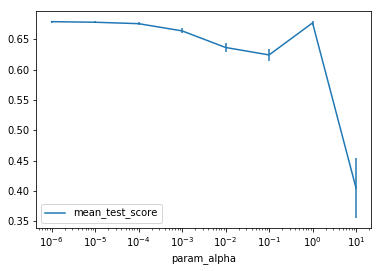

In [16]:
df = pd.DataFrame(grid.cv_results_)
show = df[df.param_loss == grid.best_params_['loss']]
show.plot(x='param_alpha', y='mean_test_score', yerr='std_test_score',
          logx=True)

But what if other losses were equally good? Let's see a visualization of the different losses *and* different regularization parameters.

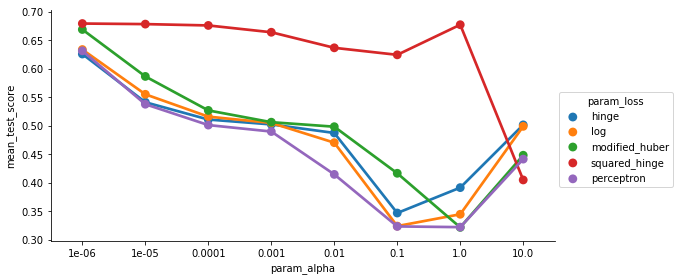

In [17]:
import seaborn as sns
sns.factorplot(x='param_alpha', y='mean_test_score', hue='param_loss',
               data=df,
               aspect=2)